# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.model_selection import cross_validate

import matplotlib.pyplot as plot


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Pre-processing

### portfolio.json

In [2]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


`channels` might be important to identify behavioral patterns since some people react differently to the offers coming from specific channels. To use this data, we need to create separate columns for each channel.

In [4]:
channels = ['web','email','mobile','social']

for channel in channels:
    portfolio[channel] = portfolio.channels.apply(lambda x: 1 if channel in x else 0)
    
portfolio.drop('channels', axis=1, inplace=True)

`duration` unit is *days*, whereas in the transcript dataset we have `time` measure in *hours*, so we need to convert `duration` unit from days to hours.

In [5]:
portfolio['duration'] *= 24

In [6]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [7]:
portfolio.rename(columns={"id": "offer_id"},inplace=True)

In [8]:
portfolio.duplicated().sum()

0

In [9]:
portfolio

,difficulty,duration,offer_id,offer_type,reward,web,email,mobile,social
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,72,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


### profile.json

In [10]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [12]:
profile.isnull().sum() / profile.shape[0]

age                 0.000000
became_member_on    0.000000
gender              0.127941
id                  0.000000
income              0.127941
dtype: float64

Let's check if we have NaN values for `gender` and `income` for the same records.

In [13]:
x = profile.dropna()
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null int64
became_member_on    14825 non-null int64
gender              14825 non-null object
id                  14825 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


So, we can drop NaN values for the simplicity since we are going to loose %12.8 of the data.

In [14]:
profile.dropna(inplace=True)

`became_member_on` might be useful, we can convert this column to a *datetime* datatype. And, we can calculate time elapsed till '2018-08-01' to get numeric value for this field.  
**Assumption**: '2018-08-01' is a magical datetime, we don't know when this dataset is actually extracted so, I got rounded value of the max value for this field. Ideally, we should calculate elapsed time when *transcript* dataset is extracted.

In [15]:
profile.became_member_on.max()

20180726

In [16]:
profile.became_member_on = pd.to_datetime(profile.became_member_on, format='%Y%m%d')
profile['became_member_diff'] = (pd.to_datetime('2018-08-01') - profile['became_member_on']).dt.days
profile.drop('became_member_on',axis=1,inplace=True)

In [17]:
profile.rename(columns={"id": "customer_id"},inplace=True)

In [18]:
profile.duplicated().sum()

0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a27eda0>,
      dtype=object)

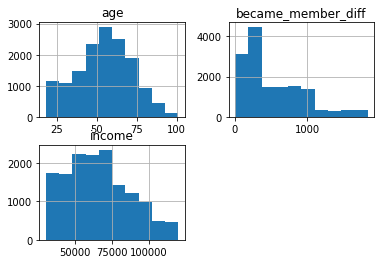

In [19]:
profile.hist()

In [20]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [21]:
profile.customer_id.nunique()

14825

In [22]:
profile[:5]

,age,gender,customer_id,income,became_member_diff
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,382
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,449
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,97
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,173
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,263


### transcript.json

In [23]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [24]:
transcript[:5]

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [25]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

We need to create separate columns for `offer_id` and `amount` since they are embedded into 1 column.

In [26]:
transcript['offer_id'] = transcript.value.apply(lambda x: x[list(x.keys())[0]] if list(x.keys())[0] in ['offer id','offer_id'] else None)
transcript['amount'] = transcript.value.apply(lambda x: x['amount'] if 'amount' in x.keys() else None)

transcript.drop(columns=['value'], inplace=True)


In [27]:
transcript.isnull().sum()

event            0
person           0
time             0
offer_id    138953
amount      167581
dtype: int64

In [28]:
len(transcript[pd.isna(transcript.offer_id)]) + len(transcript[pd.isna(transcript.amount)]) == transcript.shape[0]

True

This shows us we have `amount` or `offer_id` info available exclusively.

`person` column keeps customer id info, so we can rename it to make it clear.

In [29]:
transcript.rename(columns={"person": "customer_id"},inplace=True)

Let's check if we have matching **offer_id** s with our *portfolio* dataset.

In [30]:
transcript[transcript.offer_id.isin(portfolio.offer_id)].offer_id.nunique()

10

Let's check if we have known customers in our *transcript* dataset.

In [31]:
len(transcript[~transcript.customer_id.isin(profile.customer_id)])

33772

We can remove the customers that we don't have any profile information.

In [32]:
transcript = transcript[transcript.customer_id.isin(profile.customer_id)]

In [33]:
transcript.duplicated().sum()

374

In [34]:
transcript.drop_duplicates(inplace=True)

## Data Exploration

We've done initial analysis of the datasets. Now, we can merge them or extract relevant information to acquire input dataset to our machine learning model.  

We can merge `portfolio` and `transcript` to analyze data further.

In [35]:
portfolio_transcript = pd.merge(transcript,portfolio,on='offer_id',how='left')

In [36]:
portfolio_transcript[:3]

,event,customer_id,time,offer_id,amount,difficulty,duration,offer_type,reward,web,email,mobile,social
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,168.0,bogo,5.0,1.0,1.0,1.0,0.0
1,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,10.0,168.0,discount,2.0,1.0,1.0,1.0,0.0
2,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,120.0,bogo,5.0,1.0,1.0,1.0,1.0


In [37]:
portfolio_transcript.event.value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32070
Name: event, dtype: int64

User actions are recorded with `offer viewed`, `transaction` and `offer completed` event types. `offer received` is like a system log to see if we were able to send the offers that we want customers to see. So, we can filter out `offer received` event types since they do not mean anything useful in terms of behavioral patterns of the users. 


In [38]:
portfolio_transcript = portfolio_transcript[portfolio_transcript.event != 'offer received']

An offer is actually successful if a user views the offer and completes it. Merely completing an offer does not mean that a user is affected by that offer or not.  

**Assumption**: We can say that after an offer is viewed by a user, following transactions within the offer duration are affected by that offer.

As you can see in the below code cell, I've filtered the viewed offers first, calculated total transaction amounts during the validity of the offers, and then checked if the offers were completed or not.


In [39]:
offers = []

offers_viewed = portfolio_transcript[portfolio_transcript.event == 'offer viewed']
offers_completed = portfolio_transcript[portfolio_transcript.event == 'offer completed']
transactions = portfolio_transcript[portfolio_transcript.event == 'transaction']

for index, offer in offers_viewed.iterrows():
    customer_id = offer.customer_id
    start_time = offer.time
    end_time = int(start_time + offer.duration)

    within_time = np.logical_and(transactions.time <= end_time, transactions.time >= start_time)
    transaction_amount = transactions[(within_time) & (transactions.customer_id == customer_id)]['amount'].sum()

    within_time = np.logical_and(offers_completed.time <= end_time, offers_completed.time >= start_time)
    n_completed = len(offers_completed[(offers_completed.customer_id == customer_id) & (offers_completed.offer_id == offer.offer_id) & within_time])
    
    customer_offer = {
        'customer_id': customer_id,
        'offer_id': offer.offer_id,
        'start_time': start_time,
        'difficulty': offer.difficulty,
        'duration': offer.duration,
        'type': offer.offer_type,
        'reward': offer.reward,
        'web': offer.web,
        'email': offer.email,
        'mobile': offer.mobile,
        'social': offer.social,
        'transaction_amount': transaction_amount,
        'completed': n_completed
        }
    
    offers.append(customer_offer)

customer_offers = pd.DataFrame(offers)
    

In [40]:
customer_offers[:2]

,completed,customer_id,difficulty,duration,email,mobile,offer_id,reward,social,start_time,transaction_amount,type,web
0,1,389bc3fa690240e798340f5a15918d5c,5.0,120.0,1.0,1.0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1.0,0,9.54,bogo,1.0
1,0,d1ede868e29245ea91818a903fec04c6,0.0,72.0,1.0,1.0,5a8bc65990b245e5a138643cd4eb9837,0.0,1.0,0,1.72,informational,0.0


To make `offer_id` more readable, I'm going to encode the values.

In [41]:
def replace_value(org_value, new_value):
    customer_offers.loc[customer_offers.offer_id == org_value,'offer_id'] = new_value

for index, offer_id in enumerate(customer_offers.offer_id.unique()):
    replace_value(offer_id, 'offer_' + str(index + 1))

In [42]:
customer_offers[:2]

,completed,customer_id,difficulty,duration,email,mobile,offer_id,reward,social,start_time,transaction_amount,type,web
0,1,389bc3fa690240e798340f5a15918d5c,5.0,120.0,1.0,1.0,offer_1,5.0,1.0,0,9.54,bogo,1.0
1,0,d1ede868e29245ea91818a903fec04c6,0.0,72.0,1.0,1.0,offer_2,0.0,1.0,0,1.72,informational,0.0


Now, we can merge `customer_offers` with `profile` dataset to get demographic information.

In [43]:
customer_profile = pd.merge(customer_offers,profile,on='customer_id')

No need to keep `customer_id` since it is just a record value, we can drop it.

In [44]:
customer_profile.drop('customer_id',axis=1,inplace=True)


In [45]:
customer_profile[:2]

,completed,difficulty,duration,email,mobile,offer_id,reward,social,start_time,transaction_amount,type,web,age,gender,income,became_member_diff
0,1,5.0,120.0,1.0,1.0,offer_1,5.0,1.0,0,9.54,bogo,1.0,65,M,53000.0,173
1,0,5.0,168.0,1.0,1.0,offer_7,5.0,0.0,192,0.00,bogo,1.0,65,M,53000.0,173


## Model Building

I'm going to build a model to identify if an offer is going to be completed by a user or not to find out effective offers for individual users.  

So, our target field is `completed`, and the rest of the columns are our feature columns.

In [46]:
target = customer_profile['completed']
features = customer_profile.drop('completed', axis=1)

In [47]:
features[:2]

,difficulty,duration,email,mobile,offer_id,reward,social,start_time,transaction_amount,type,web,age,gender,income,became_member_diff
0,5.0,120.0,1.0,1.0,offer_1,5.0,1.0,0,9.54,bogo,1.0,65,M,53000.0,173
1,5.0,168.0,1.0,1.0,offer_7,5.0,0.0,192,0.00,bogo,1.0,65,M,53000.0,173


Since we have columns with string datatype, we need to encode them to convert into numerical values.

In [48]:
features = pd.get_dummies(features)

In [49]:
features[:2]

,difficulty,duration,email,mobile,reward,social,start_time,transaction_amount,web,age,...,offer_id_offer_6,offer_id_offer_7,offer_id_offer_8,offer_id_offer_9,type_bogo,type_discount,type_informational,gender_F,gender_M,gender_O
0,5.0,120.0,1.0,1.0,5.0,1.0,0,9.54,1.0,65,...,0,0,0,0,1,0,0,0,1,0
1,5.0,168.0,1.0,1.0,5.0,0.0,192,0.00,1.0,65,...,0,1,0,0,1,0,0,0,1,0


In [50]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49860 entries, 0 to 49859
Data columns (total 28 columns):
difficulty            49860 non-null float64
duration              49860 non-null float64
email                 49860 non-null float64
mobile                49860 non-null float64
reward                49860 non-null float64
social                49860 non-null float64
start_time            49860 non-null int64
transaction_amount    49860 non-null float64
web                   49860 non-null float64
age                   49860 non-null int64
income                49860 non-null float64
became_member_diff    49860 non-null int64
offer_id_offer_1      49860 non-null uint8
offer_id_offer_10     49860 non-null uint8
offer_id_offer_2      49860 non-null uint8
offer_id_offer_3      49860 non-null uint8
offer_id_offer_4      49860 non-null uint8
offer_id_offer_5      49860 non-null uint8
offer_id_offer_6      49860 non-null uint8
offer_id_offer_7      49860 non-null uint8
offer_id_offe

Data type conversions are added in the next cell to eliminate StandartScaler conversion warnings.

In [51]:
features['start_time'] = features['start_time'].astype(float)
features['age'] = features['age'].astype(float)
features['became_member_diff'] = features['became_member_diff'].astype(float)
features['offer_id_offer_1'] = features['offer_id_offer_1'].astype(float)
features['offer_id_offer_2'] = features['offer_id_offer_2'].astype(float)
features['offer_id_offer_3'] = features['offer_id_offer_3'].astype(float)
features['offer_id_offer_4'] = features['offer_id_offer_4'].astype(float)
features['offer_id_offer_5'] = features['offer_id_offer_5'].astype(float)
features['offer_id_offer_6'] = features['offer_id_offer_6'].astype(float)
features['offer_id_offer_7'] = features['offer_id_offer_7'].astype(float)
features['offer_id_offer_8'] = features['offer_id_offer_8'].astype(float)
features['offer_id_offer_9'] = features['offer_id_offer_9'].astype(float)
features['offer_id_offer_10'] = features['offer_id_offer_10'].astype(float)
features['type_bogo'] = features['type_bogo'].astype(float)
features['type_discount'] = features['type_discount'].astype(float)
features['type_informational'] = features['type_informational'].astype(float)
features['gender_F'] = features['gender_F'].astype(float)
features['gender_M'] = features['gender_M'].astype(float)
features['gender_O'] = features['gender_O'].astype(float)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a333be0>,
      dtype=object)

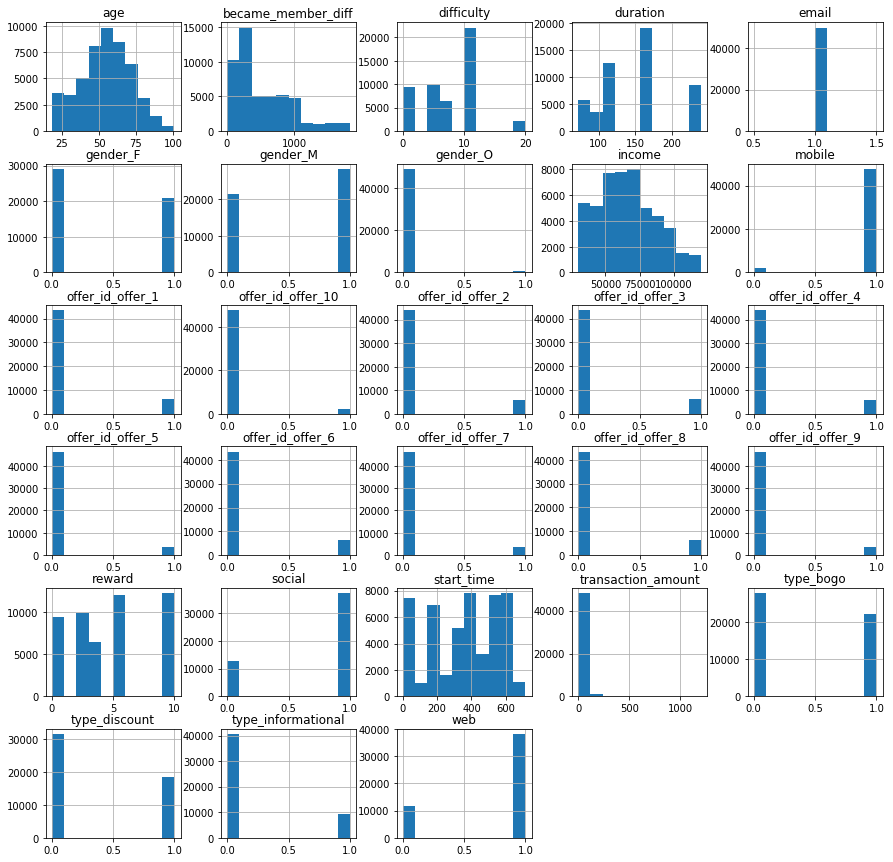

In [52]:
features.hist(figsize=(15,15))

As you can see in the histograms, the numerical ranges are not so different from each other, but it is a good practise to keep them similar to each other in terms of building an efficient model.  

Let's split our dataset into train and test sets.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 34902 samples.
Testing set has 14958 samples.


I'm going to try different classification algorithms.  
**PS**: The parameters in the algorithm constructors are given to eliminate warnings. 

In [54]:
clfs = []

pipeline = Pipeline([
    ('normalizer', StandardScaler()), 
    ('clf', KNeighborsClassifier())
]) 

clfs = []
clfs.append(KNeighborsClassifier())
clfs.append(DecisionTreeClassifier(random_state=0))
clfs.append(RandomForestClassifier(n_estimators=100, random_state=0))
clfs.append(GradientBoostingClassifier(random_state=0))
clfs.append(LogisticRegression(random_state=0,max_iter=1000,solver='lbfgs',multi_class='auto'))
clfs.append(SVC(random_state=0, gamma='scale'))

for classifier in clfs:
    pipeline.set_params(clf = classifier)
    scores = cross_validate(pipeline, X_train, y_train, cv=5)
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    for key, values in scores.items():
            print(key,' => ', values.mean())


---------------------------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
-----------------------------------
fit_time  =>  0.39660181999206545
score_time  =>  3.8894419193267824
test_score  =>  0.7899556148945379
train_score  =>  0.8538837646442865
---------------------------------
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')
-----------------------------------
fit_time  =>  0.16516332626342772
score_time  =>  0.00387425422668457
test_score  =>  0.8259986820812248
train_score  =>  1.0
---------------------------------
RandomForestClassifier(bootstrap=True, class_w

`GradientBoostingClassifier` is the most successful one so, we can select `GradientBoostingClassifier` as our model.

In [55]:
pipeline = Pipeline([
    ('normalizer', StandardScaler()), 
    ('gbc', GradientBoostingClassifier(random_state=0))
])             

pipeline.fit(X_train, y_train)
print("Accuracy score for the test data set = %3.2f" %(pipeline.score(X_test,y_test)))


Accuracy score for the test data set = 0.88


And, the accuracy score for the test dataset is 0.88.

## Data Analysis

**Q1**: Which fields provide the most predictive power?

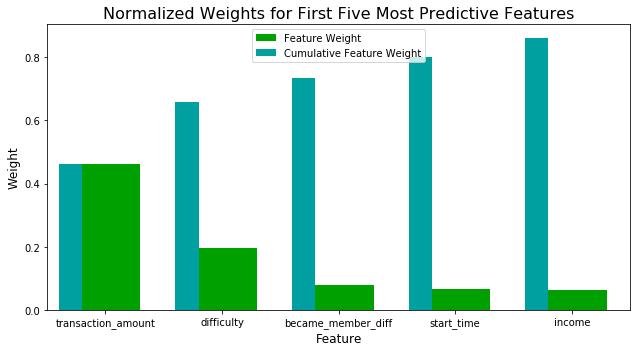

In [56]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plot.figure(figsize = (9,5))
    plot.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plot.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plot.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plot.xticks(np.arange(5), columns)
    plot.xlim((-0.5, 4.5))
    plot.ylabel("Weight", fontsize = 12)
    plot.xlabel("Feature", fontsize = 12)
    
    plot.legend(loc = 'upper center')
    plot.tight_layout()
    plot.show()  
    
    
model = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
importances = model.feature_importances_
feature_plot(importances, X_train, y_train)

It seems like our assumption was right since `transaction_amount` is the first one having the most predictive power. `difficulty` and `became_member_diff` come next.  
`start_time` is the interesting one, maybe this is because offers are valid within a specific period of time and timely transactions matter to achieve completing the offer or not.   
`income` is surely an important factor showing financial power of an individual.

**Q2**: Which gender is completing offers the most?

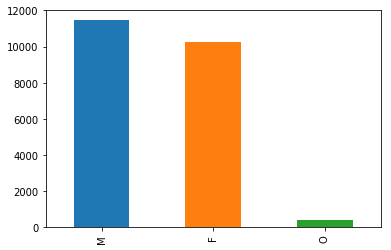

In [61]:
customer_profile[customer_profile.completed == 1].gender.value_counts().plot(kind='bar')

Men are completing offers more than women. Maybe this is because they drink more or they are more careful on following offers.